In [1]:
%matplotlib inline

In [2]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
import matplotlib

# Agg backend for non-GUI rendering
# matplotlib.use('TkAgg')

# CSV file load
file_path = r"C:\..\aggregated_daily_load.csv"
daily_df = pd.read_csv(file_path)
print(daily_df.head())

# We parse 'time' as datetime and an index
daily_df['time'] = pd.to_datetime(daily_df['time'])

daily_df.set_index('time', inplace=True)

# Let's define the data for training and testing. We can always change the size of these, at our convenience.
train_data = daily_df.loc['2020-01-01':'2020-10-31', 'load']
test_data = daily_df.loc['2020-11-01':"2020-12-31", 'load']

         time              from                to          load      residual  \
0  2018-11-01  01.11.2018 00:00  02.11.2018 00:00  55435.677083  41248.750000   
1  2018-11-02  02.11.2018 00:00  03.11.2018 00:00  58741.354167  42638.614583   
2  2018-11-03  03.11.2018 00:00  04.11.2018 00:00  52306.989583  43333.406250   
3  2018-11-04  04.11.2018 00:00  05.11.2018 00:00  48647.406250  39556.520833   
4  2018-11-05  05.11.2018 00:00  06.11.2018 00:00  60938.635417  50280.781250   

        pumped  month  weekday  hour  
0  1779.239583     11        3    23  
1  1374.125000     11        4    23  
2  1228.177083     11        5    23  
3  1411.552083     11        6    23  
4  1394.739583     11        0    23  


In [3]:
# Stationary check using the ADF test
result = adfuller(train_data)  # note that is achieved on the trained data
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# We are now going to scale the data sets to obtain a more stable outcome
scaler = StandardScaler()
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1)).flatten()
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1)).flatten()

# If the ADF test is significant, this iff statement should go through
if result[1] > 0.05:
    train_data_diff = pd.Series(scaled_train_data).diff().dropna().values
else:
    train_data_diff = scaled_train_data

# Define and fit the SARIMAX model
mod = SARIMAX(train_data_diff, order=(2, 1, 2), seasonal_order=(2, 1, 1, 7))
sarima_result = mod.fit(disp=False)

# The model summary
print(sarima_result.summary())

ADF Statistic: -1.6350773459199044
p-value: 0.4648341630434809
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  304
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 7)   Log Likelihood                 -82.431
Date:                             Mon, 09 Dec 2024   AIC                            180.862
Time:                                     20:36:42   BIC                            210.385
Sample:                                          0   HQIC                           192.682
                                             - 304                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5252      0.085      6.145

c:\Users\fanek\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [4]:
# Next step: forecasting the test data
forecast = sarima_result.get_forecast(steps=len(scaled_test_data))
forecast_index = test_data.index
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

# Again we rescale the results
forecast_mean_rescaled = scaler.inverse_transform(forecast_mean.reshape(-1, 1)).flatten()
test_rescaled = scaler.inverse_transform(scaled_test_data.reshape(-1, 1)).flatten()

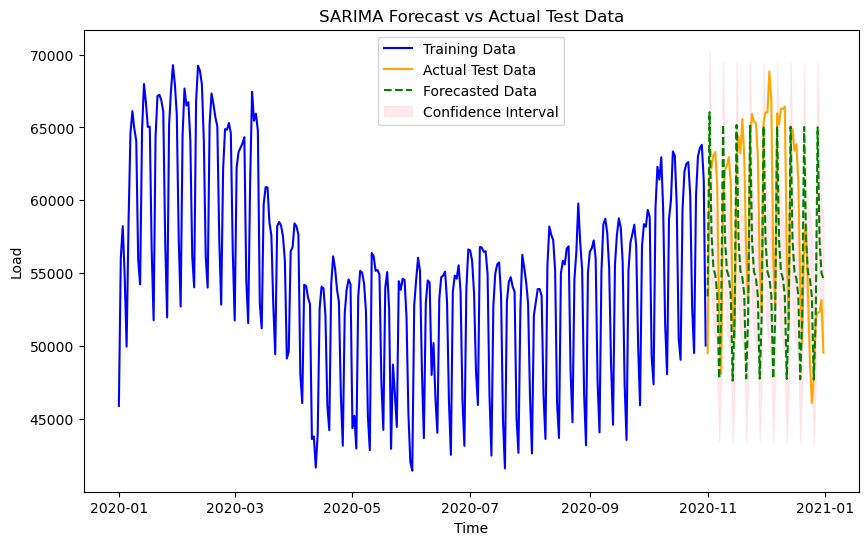

In [5]:
# Plot of the forecasted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_rescaled, label='Actual Test Data', color='orange')
plt.plot(forecast_index, forecast_mean_rescaled, label='Forecasted Data', color='green', linestyle='--')
plt.fill_between(
    forecast_index,
    scaler.inverse_transform(forecast_conf_int[:, 0].reshape(-1, 1)).flatten(),
    scaler.inverse_transform(forecast_conf_int[:, 1].reshape(-1, 1)).flatten(),

    color='pink',
    alpha=0.3,
    label='Confidence Interval'
)
plt.title('SARIMA Forecast vs Actual Test Data')
plt.xlabel('Time')
plt.ylabel('Load')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

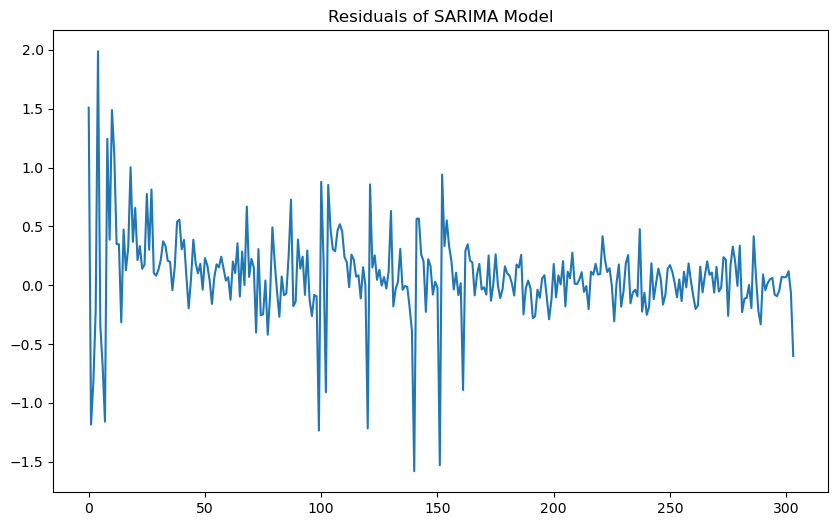

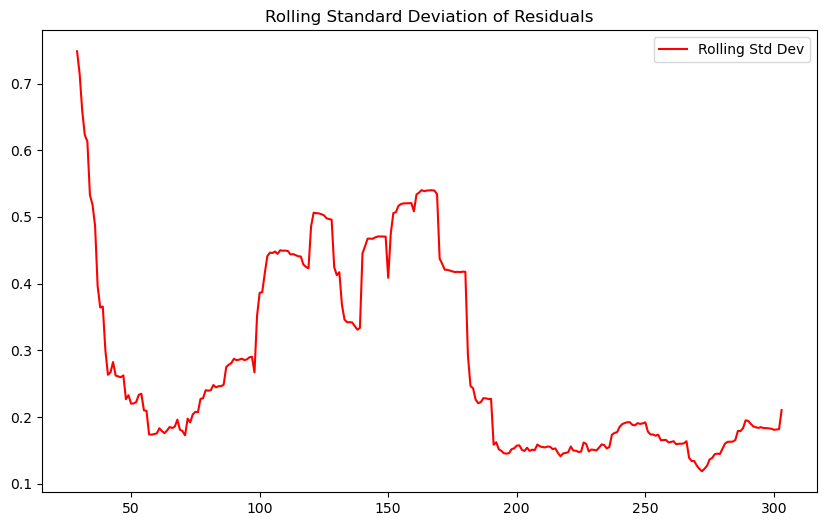

In [6]:
# Save the plot
plt.savefig('sarima_forecast_vs_actual.png')

# Next Step: This step comes in to observe the heteroskedastic residual variance
# Plot the residuals of the SARIMA model.
plt.figure(figsize=(10, 6))
plt.plot(sarima_result.resid, label="Residuals")
plt.title("Residuals of SARIMA Model")

rolling_std = pd.Series(sarima_result.resid).rolling(window=30).std()

# Plot the rolling standard deviation
plt.figure(figsize=(10, 6))
plt.plot(rolling_std, label="Rolling Std Dev", color="red")
plt.title("Rolling Standard Deviation of Residuals")
plt.legend()
#plt.savefig('sarima_rolling_std_residuals.png')
plt.show()
